In [3]:
# 使jupyter能够交互式显示图像
%matplotlib notebook

import json
import datetime

import pandas as pd
from numpy import array
import numpy as np
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import matplotlib.figure as fig
   
from pyspark.sql import *
import matplotlib.font_manager as fm
my_font=fm.FontProperties(fname="/Users/ppx/Desktop/中文字体/simsun.ttf")

In [4]:
# 加载 LEWTEB144HE103899 数据
data=spark.read.json("hdfs://cdh1:8020/user/hbase/pro_dfjk4new/fault_data/2019-07-25/")
data.first()

Row(battery_cell_consistency_low_alert='False', battery_cell_voltage_highest_value='3.72', battery_cell_voltage_lowest_value='3.65', battery_fault_codes='[]', battery_faults_count='0', battery_high_temperature_alert='False', braking_system_alert='False', charge_status='\\xE6\\x9C\\xAA\\xE5\\x85\\x85\\xE7\\x94\\xB5', current='-11.2', dc_dc_status_alert='False', dc_dc_temperature_alert='False', energy_storage_device_high_voltage_alert='False', energy_storage_device_low_voltage_alert='False', energy_storage_device_over_charge_alert='False', has_alert='false', highest_alert_level='\\xE6\\x97\\xA0\\xE6\\x95\\x85\\xE9\\x9A\\x9C', hvil_alert='False', insulation_alert='False', maximum_temperature_value='36', minimum_temperature_value='34', motor_controller_temperature_alert='False', motor_temperature_alert='False', obd_time='2019-07-25 00:00:08', rechargeable_energy_storage_system_mismatch_alert='False', resd_subsystem_count='1', resd_subsystem_temperature_list="[{'subsystem_probe_temperature_

In [10]:
# 使用pandas合并
# 提取resd_subsystem_voltage_list列表的数据转为列
resd_subsystem_voltage_list1=data.select("resd_subsystem_voltage_list").rdd.map(lambda x:(eval(x[0])[0])).toDF()

# 使用pandas设置索引
pdf1=resd_subsystem_voltage_list1.toPandas()
pdf1.insert(0,"index1",pdf1.index)

# 获取电池组数据
battery_cell_voltage_list1=resd_subsystem_voltage_list1.select(resd_subsystem_voltage_list1.battery_cell_voltage_list)\
                            .rdd.map(lambda x:x[0]).toDF()

pdf2=battery_cell_voltage_list1.toPandas()
pdf2.insert(0,"index2",pdf2.index)

# 合并resd_subsystem_voltage_list表
resd_subsystem_voltage_list=pdf1.join(pdf2,how="inner")
resd_subsystem_voltage_list=pd.concat([pdf1,pdf2],axis=1,join="inner")

# 合并全表
pdf3=data.toPandas()
pdf3.insert(0,"index",pdf3.index)
# data21=pdf3.join(resd_subsystem_voltage_list,how="inner")
data21=pd.concat([pdf3,resd_subsystem_voltage_list],axis=1,join="inner")
data21['battery_cell_voltage_list']

# 提取电池组电压
battery_voltage_list=pdf2.drop("index2",axis=1).round(decimals=2)
type(battery_voltage_list)
# 求方差，每行数据的方差
np.var(battery_voltage_list,axis=1)

/Users/ppx/workspace/spark-2.4.4-bin-hadoop2.7/python/pyspark/sql/session.py:366: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


0      [3.7, 3.68, 3.69, 3.67, 3.68, 3.7, 3.69, 3.69,...
1      [3.7, 3.68, 3.69, 3.68, 3.69, 3.69, 3.68, 3.69...
2      [3.7, 3.69, 3.69, 3.68, 3.69, 3.7, 3.69, 3.69,...
3      [3.68, 3.66, 3.66, 3.65, 3.66, 3.67, 3.65, 3.6...
4      [3.72, 3.71, 3.72, 3.71, 3.71, 3.72, 3.72, 3.7...
                             ...                        
183    [3.85, 3.83, 3.84, 3.84, 3.84, 3.85, 3.84, 3.8...
184    [3.85, 3.83, 3.84, 3.84, 3.84, 3.85, 3.84, 3.8...
185    [3.85, 3.83, 3.84, 3.84, 3.84, 3.85, 3.84, 3.8...
186    [3.85, 3.83, 3.84, 3.84, 3.84, 3.85, 3.84, 3.8...
187    [3.85, 3.83, 3.84, 3.84, 3.84, 3.85, 3.84, 3.8...
Name: battery_cell_voltage_list, Length: 188, dtype: object

pandas.core.frame.DataFrame

0      0.000195
1      0.000102
2      0.000129
3      0.000131
4      0.000089
         ...   
183    0.000191
184    0.000190
185    0.000190
186    0.000190
187    0.000186
Length: 188, dtype: float64

In [ ]:
list1=[]
for n in data21['battery_cell_voltage_list']:
    list1.append(np.var(n).round(4))
data21['battery_cell_voltage_list_var']=list1

data21['battery_cell_voltage_list_var']=data21['battery_cell_voltage_list_var'].astype('double')

data21['obd_time'] = pd.to_datetime(data21['obd_time'])
data21.set_index('obd_time',inplace=True)

# 设置x.y坐标
_x = data21.index
_y1 = data21.battery_cell_voltage_list_var

plt.figure(figsize=(100,5),dpi=60,edgecolor="blue",facecolor="lightpink")
plt.subplots_adjust(left=0.01,right=0.995,top=0.9,bottom=0.4)

plt.title('电池组方差图',fontproperties=my_font,fontsize=20,pad=1)
plt.plot(range(len(_x)),_y1,color='r')
plt.xlim(0,20)
# plt.ylim()
plt.grid()
plt.xticks(range(len(_x)),_x,rotation=90,fontsize=12)
plt.yticks(fontsize=12)
# plt.xlabel('单位:s',fontproperties=my_font)
# plt.ylabel('单位：V',fontproperties=my_font,fontsize=15,rotation=90)


plt.savefig("/Users/ppx/Desktop/picture/LEWTEB142JN101333电池组方差图.jpg")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


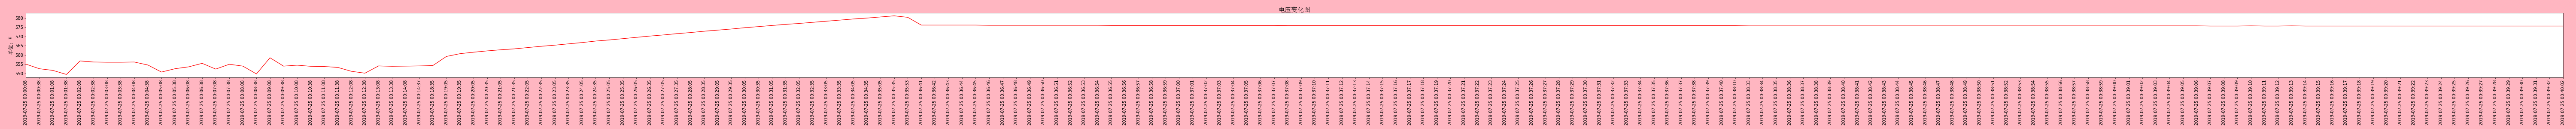

<IPython.core.display.Javascript object>


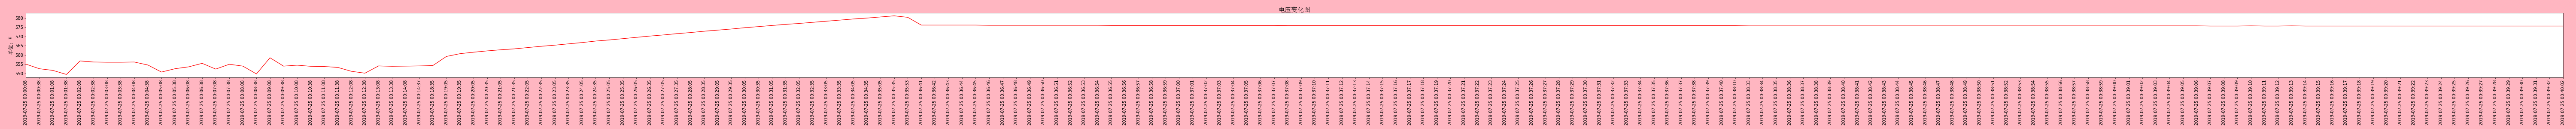

Text(0.5, 1.0, '电压变化图')

(0, 20)

([<matplotlib.axis.XTick at 0x11a2a7128>,
 <a list of 188 Text xticklabel objects>)

(array([545., 550., 555., 560., 565., 570., 575., 580., 585.]),
 <a list of 9 Text yticklabel objects>)

Text(0, 0.5, '单位：V')

In [11]:
# 电压趋势图
data1=data.toPandas()
data2=pd.DataFrame(data1[['obd_time','voltage']])
data2['voltage']=data2['voltage'].astype('double')

# 设置时间间隔，随数据条数画图可以不设置
# pd.date_range(start='2018-08-08 00:00:00',end='2018-08-08 23:59:59',freq='H')

# 1.将时间字段（字符串类型）转为pandas的时间类型
data2['obd_time'] = pd.to_datetime(data2['obd_time'])

# 2.将时间字段设置为索引,inplace表示原地调整
data2.set_index('obd_time',inplace=True)

# 测试设置索引是否成功
# data2['2018-08-08 00:05:48':]

# 3.为坐标指定索引和值，绘图使用的是索引为横坐标
_x = data2.index
_y = data2.values

plt.figure(figsize=(100,5),dpi=60,edgecolor="blue",facecolor="lightpink")
plt.subplots_adjust(left=0.01,right=0.995,top=0.9,bottom=0.4)
plt.title('电压变化图',fontproperties=my_font,fontsize=18,pad=1)

plt.plot(range(len(_x)),_y,color='r')
plt.xlim(0,20)
# plt.ylim()
plt.xticks(range(len(_x)),_x,rotation=90,fontsize=12)
plt.yticks(fontsize=12)
# plt.xlabel('单位:s',fontproperties=my_font)
plt.ylabel('单位：V',fontproperties=my_font,fontsize=15,rotation=90)

plt.savefig("/Users/ppx/Desktop/picture/LEWTEB142JN101333电压变化图.jpg")
plt.show()

<IPython.core.display.Javascript object>


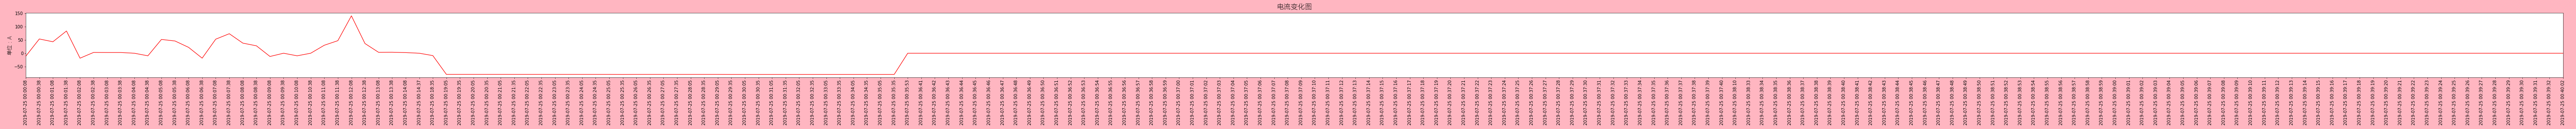

<IPython.core.display.Javascript object>


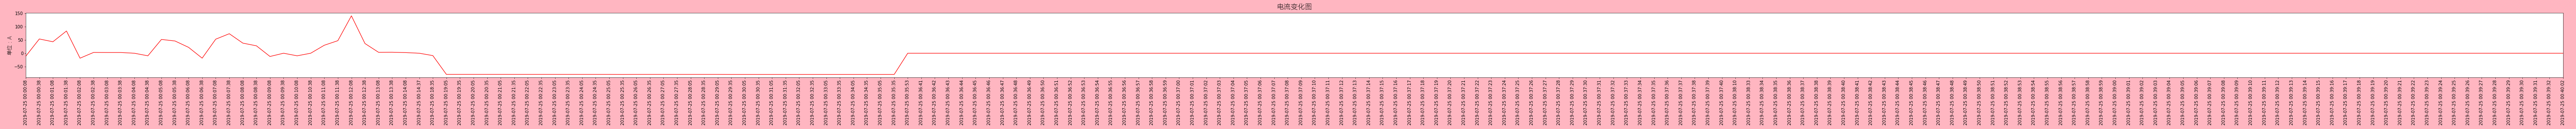

Text(0.5, 1.0, '电流变化图')

(0, 20)

([<matplotlib.axis.XTick at 0x11a47d390>,
 <a list of 188 Text xticklabel objects>)

(array([-100.,  -50.,    0.,   50.,  100.,  150.,  200.]),
 <a list of 7 Text yticklabel objects>)

Text(0, 0.5, '单位：A')

In [7]:
# 电流变化图

data3=pd.DataFrame(data1[['obd_time','current']])
data3['current']=data3['current'].astype('double')

# 设置时间间隔，随数据条数画图可以不设置
# pd.date_range(start='2018-08-08 00:00:00',end='2018-08-08 23:59:59',freq='H')

# 1.将时间字段（字符串类型）转为pandas的时间类型
data3['obd_time'] = pd.to_datetime(data3['obd_time'])

# 2.将时间字段设置为索引,inplace表示原地调整
data3.set_index('obd_time',inplace=True)

# 测试设置索引是否成功
# data2['2018-08-08 00:05:48':]

# 3.为坐标指定索引和值，绘图使用的是索引为横坐标
_x = data3.index
_y = data3.values

plt.figure(figsize=(100,5),dpi=60,edgecolor="blue",facecolor="lightpink")
plt.subplots_adjust(left=0.01,right=0.995,top=0.9,bottom=0.4)
plt.title('电流变化图',fontproperties=my_font,fontsize=20,pad=10)

plt.plot(range(len(_x)),_y,color='r')
plt.xlim(0,20)
# plt.ylim()
plt.xticks(range(len(_x)),_x,rotation=90,fontsize=12)
plt.yticks(fontsize=12)
# plt.xlabel('单位:s',fontproperties=my_font)
plt.ylabel('单位：A',fontproperties=my_font,fontsize=15,rotation=90)

plt.savefig("/Users/ppx/Desktop/picture/LEWTEB142JN101333电流变化图.jpg")
plt.show()

<IPython.core.display.Javascript object>


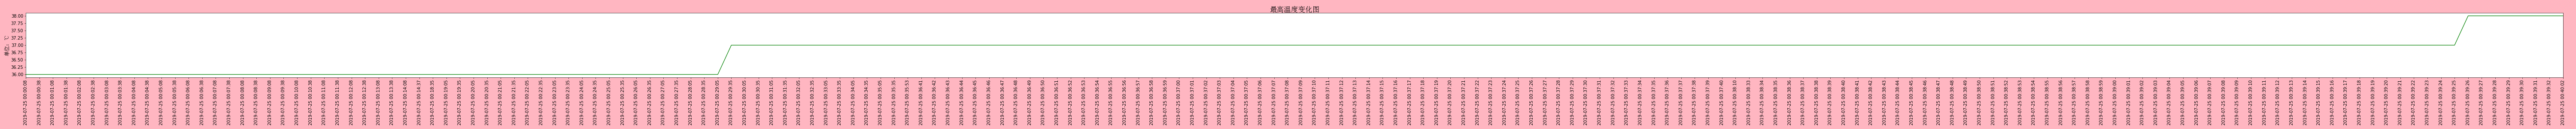

<IPython.core.display.Javascript object>


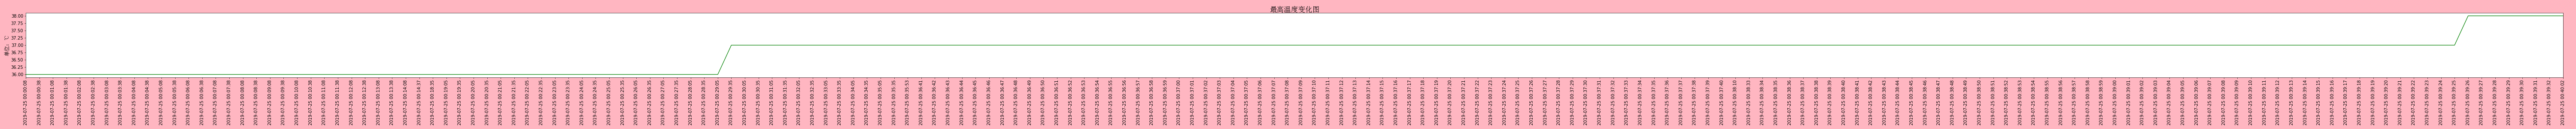

Text(0.5, 1.0, '最高温度变化图')

(0, 20)

([<matplotlib.axis.XTick at 0x11ab415f8>,
 <a list of 188 Text xticklabel objects>)

(array([35.75, 36.  , 36.25, 36.5 , 36.75, 37.  , 37.25, 37.5 , 37.75,
        38.  , 38.25]), <a list of 11 Text yticklabel objects>)

Text(0, 0.5, '单位：℃')

In [12]:
# 最高温度变化图

data4=pd.DataFrame(data1[['obd_time','maximum_temperature_value']])
data4['maximum_temperature_value']=data4['maximum_temperature_value'].astype('double')

# 设置时间间隔，随数据条数画图可以不设置
# pd.date_range(start='2018-08-08 00:00:00',end='2018-08-08 23:59:59',freq='H')

# 1.将时间字段（字符串类型）转为pandas的时间类型
data4['obd_time'] = pd.to_datetime(data4['obd_time'])

# 2.将时间字段设置为索引,inplace表示原地调整
data4.set_index('obd_time',inplace=True)

# 测试设置索引是否成功
# data2['2018-08-08 00:05:48':]

# 3.为坐标指定索引和值，绘图使用的是索引为横坐标
_x = data4.index
_y = data4.values

plt.figure(figsize=(100,5),dpi=60,edgecolor="blue",facecolor="lightpink")
plt.subplots_adjust(left=0.01,right=0.995,top=0.9,bottom=0.4)
plt.title('最高温度变化图',fontproperties=my_font,fontsize=20,pad=1)

plt.plot(range(len(_x)),_y,color='g')
plt.xlim(0,20)
# plt.ylim()
plt.xticks(range(len(_x)),_x,rotation=90,fontsize=12)
plt.yticks(fontsize=12)
# plt.xlabel('单位:s',fontproperties=my_font)
plt.ylabel('单位：℃',fontproperties=my_font,fontsize=15,rotation=90)

plt.savefig("/Users/ppx/Desktop/picture/LEWTEB142JN101333最高温度变化图.jpg")
plt.show()

In [ ]:
# 最低温度变化图

data5=pd.DataFrame(data1[['obd_time','minimum_temperature_value']])
data5['minimum_temperature_value']=data5['minimum_temperature_value'].astype('double')

# 设置时间间隔，随数据条数画图可以不设置
# pd.date_range(start='2018-08-08 00:00:00',end='2018-08-08 23:59:59',freq='H')

# 1.将时间字段（字符串类型）转为pandas的时间类型
data5['obd_time'] = pd.to_datetime(data5['obd_time'])

# 2.将时间字段设置为索引,inplace表示原地调整
data5.set_index('obd_time',inplace=True)

# 测试设置索引是否成功
# data2['2018-08-08 00:05:48':]

# 3.为坐标指定索引和值，绘图使用的是索引为横坐标
_x = data5.index
_y = data5.values

plt.figure(figsize=(100,10),dpi=80)
plt.title('最低温度变化图',fontproperties=my_font,loc="center",fontsize=20,pad=10)

plt.plot(range(len(_x)),_y,color='b')
# rotation表字体倾斜45度
plt.xticks(range(len(_x)),_x,rotation=45)
plt.show()